# Mean Square End-to-End Fluctuations

In [45]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from os import listdir
import pandas as pd

In [277]:
def CreateLpDataFrame(dirName):
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.mse2e']
    df = pd.DataFrame(columns=['n_filaments','length','persistence_length','driving','ndim','theory','mse2e','std_err'])
    for filename in fileNames:
        f=open(filename)
        f.readline()
        f.readline()
        line = map(float,f.readline().split())
        length,perlen,driving,ndim,theory = line[0],line[2],line[3],line[4],line[8]
        f.readline()
        line = f.readline().split()
        num,mse2e,stderr = int(line[0]),float(line[1]),float(line[2])
        f.close()
        temp_df = pd.DataFrame(data={'n_filaments':num,'length':length,'persistence_length':perlen,'driving':driving,'ndim':ndim,'theory':theory,'mse2e':mse2e,'std_err':stderr},index=[1])
        df = df.append(temp_df,ignore_index=True)
    return df

def GetRealUnits(df):
    df.loc[:,'length (nm)'] = df['length'].apply(lambda y: y*25.0)
    df.loc[:,'driving (pN/nm)'] = df['driving'].apply(lambda y: y*0.0064)
    df.loc[:,'persistence_length (nm)'] = df['persistence_length'].apply(lambda y: y*25.0)
    df.loc[:,'mse2e (nm^2)'] = df['mse2e'].apply(lambda y: y*25.0)
    df.loc[:,'std_err (nm^2)'] = df['std_err'].apply(lambda y: y*25.0)
    df.loc[:,'theory (nm^2)'] = df['theory'].apply(lambda y: y*25.0)
    df.loc[:,'effective_lp (nm)'] = df['effective_lp'].apply(lambda y: y*25.0)
    df.loc[:,'eff_lp_lower (nm)'] = df['eff_lp_lower'].apply(lambda y: y*25.0)
    df.loc[:,'eff_lp_upper (nm)'] = df['eff_lp_upper'].apply(lambda y: y*25.0)

def BackCalc(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcUpper(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']+row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcLower(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-row['std_err']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])
    
def BackCalculateLp(df,range_min=50,range_max=50000):
    df.loc[:,'effective_lp'] = df.apply(BackCalc, axis=1)
    df.loc[:,'eff_lp_lower'] = df.effective_lp - df.apply(BackCalcLower, axis=1)
    df.loc[:,'eff_lp_upper'] = df.apply(BackCalcUpper, axis=1) - df.effective_lp


### Next cell is raw text, convert back to code to rerun

In [278]:
df = CreateLpDataFrame('mse2e_analysis/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_data.pkl')

In [279]:
df = pd.read_pickle('mse2e_data.pkl')

<IPython.core.display.Javascript object>


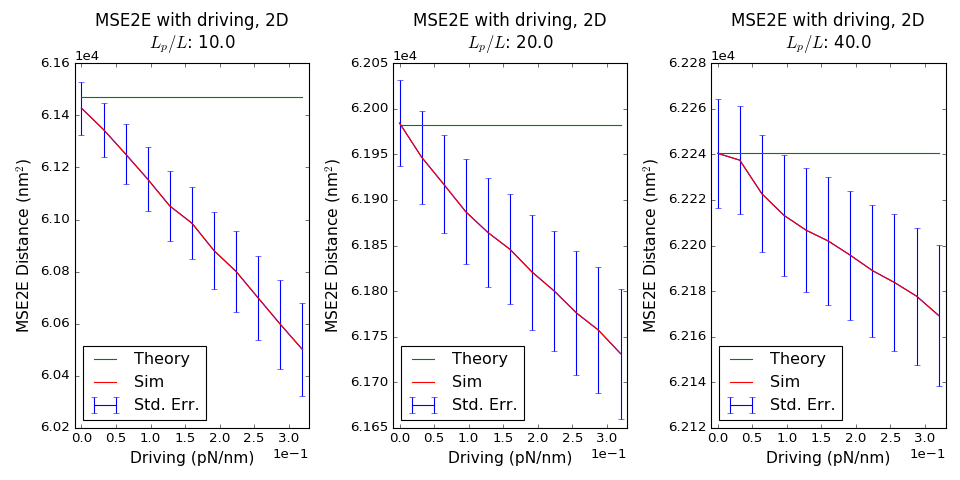

In [280]:
df2d = df[df['ndim']==2]
df3d = df[df['ndim']==3]
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 2D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend(['Theory','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

<IPython.core.display.Javascript object>


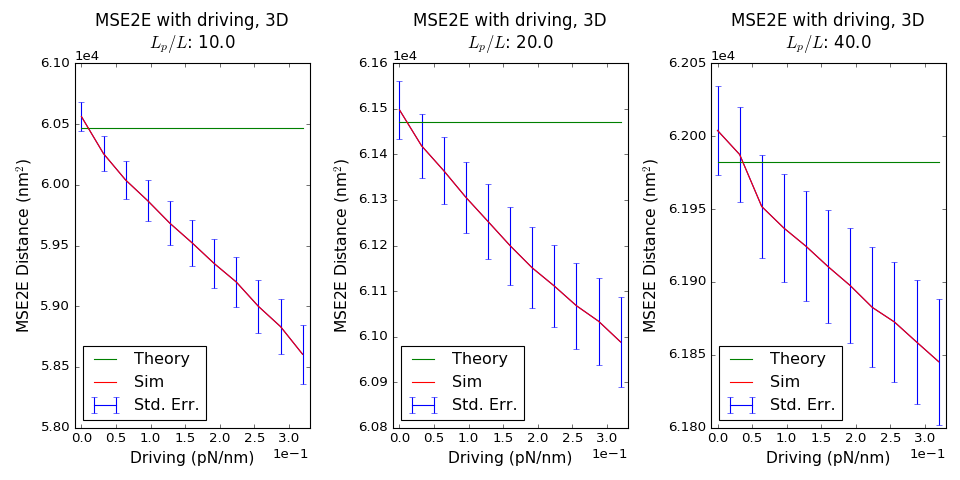

In [281]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend(['Theory','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#(rect=(0.05,0.1,0.95,0.9),pad=-1.5)
plt.show()

<IPython.core.display.Javascript object>


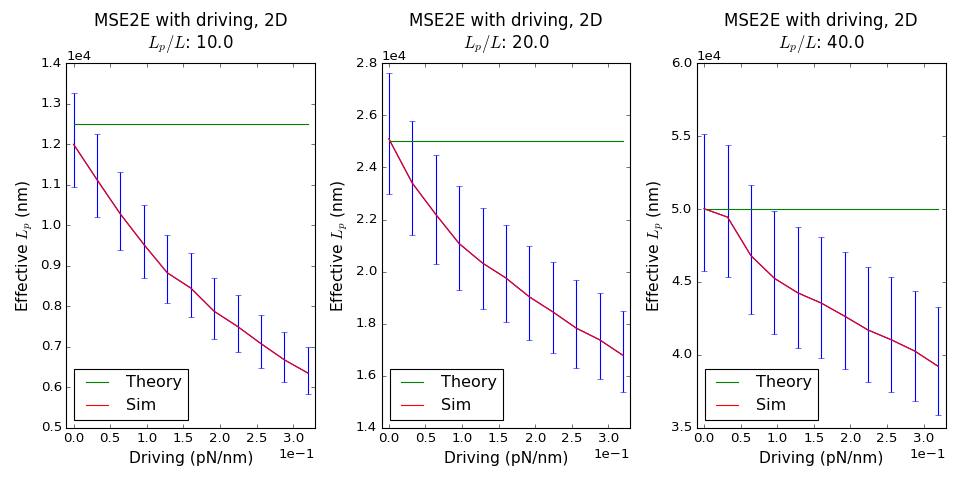

In [282]:
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 2D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)'],yerr=(group['eff_lp_lower (nm)'],group['eff_lp_upper (nm)']))
    ax[i].plot(group['driving (pN/nm)'],group['persistence_length (nm)'])
    ax[i].plot(group['driving (pN/nm)'],group['effective_lp (nm)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'Effective $L_p$ (nm)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend(['Theory','Sim'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

<IPython.core.display.Javascript object>


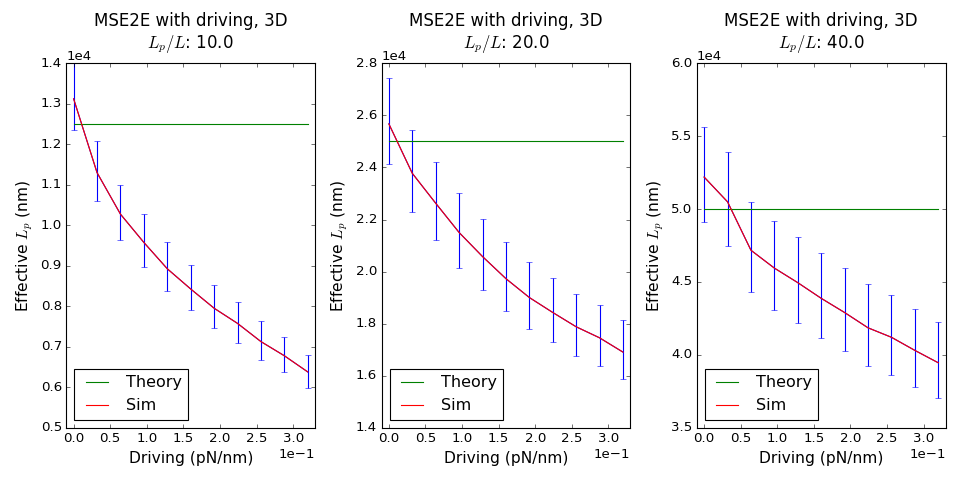

In [283]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)'],yerr=(group['eff_lp_lower (nm)'],group['eff_lp_upper (nm)']))
    ax[i].plot(group['driving (pN/nm)'],group['persistence_length (nm)'])
    ax[i].plot(group['driving (pN/nm)'],group['effective_lp (nm)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'Effective $L_p$ (nm)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend(['Theory','Sim'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

In [190]:
mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
mse2e_func(50,5000,3)

2491.6874584053294